In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.python.keras.layers import MaxPooling2D, Input, Activation
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.applications.resnet import ResNet101
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint,History,EarlyStopping
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.densenet import DenseNet121
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.models import load_model

In [ ]:
class primary_classifier():

    def __init__(self,input_shape = (224,224,3),latent_dim = 128,freezed_layers = 313,pre_activation = 'relu',dropout_rate = 0.2,batch_size = 32):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.freezed_layers = freezed_layers
        self.pre_activation = pre_activation
        self.dropout_rate = dropout_rate
        self.batch_size = batch_size

    def get_model(self):
        baseModel =  DenseNet121(weights="imagenet", include_top=False,pooling = 'avg',input_shape = self.input_shape)
        output = baseModel.output
        output = BatchNormalization()(output)
        output = Dense(self.latent_dim, activation=self.pre_activation)(output)
        output = Dropout(self.dropout_rate)(output)
        output = BatchNormalization()(output)
        output = Dense(1, activation='sigmoid')(output)
        model = Model(inputs=baseModel.input, outputs=output)
        
        for layer in baseModel.layers[:self.freezed_layers]:
            layer.trainable = False
        for layer in baseModel.layers[self.freezed_layers:]:
            layer.trainable = True
        return model

    def convert_generator_to_numpy(self, data_generator, size):
        X = []
        y = []
        for i in range(int(size / self.batch_size)):
            a,b = data_generator.next()
            for j in range(self.batch_size):
                X.append(a[j])
                y.append(b[j])

        return (np.array(X), np.array(y))
        
    def loadmodel(self, model_path):
        return load_model(model_path)

    def data_loader(self,train_data_path,test_data_path):
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            brightness_range=[0.5,1.5],
            rotation_range = 90,
            horizontal_flip=True)
        val_datagen = ImageDataGenerator(rescale=1./255)
        
        train_generator = train_datagen.flow_from_directory(
            train_data_path,
            target_size=(224, 224),
            batch_size=self.batch_size,
            class_mode='binary')
        val_generator = val_datagen.flow_from_directory(
            test_data_path,
            target_size=(224, 224),
            batch_size=self.batch_size,
            class_mode='binary')
            
        return (train_generator, val_generator)

    def train(self,model,train_generator,test_generator,train_size = 5216,test_size = 624,optimizer = 'adam',loss = 'binary_crossentropy',max_epochs = 100,use_callbacks  = False, model_file_path = 0):
        def get_callbacks(model_file_path):
            checkpoint  = ModelCheckpoint(model_file_path,monitor='val_accuracy',verbose=1,save_best_only=True,save_freq='epoch',mode='max')
            hist = History()
            lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
            callbacks = [checkpoint, hist, lr_reduce, es]
            return callbacks
            
        model.compile(loss = loss , optimizer = optimizer, metrics = ['accuracy'])
        
        if use_callbacks == True:
            callbacks = get_callbacks(model_file_path)
            model.fit_generator(train_generator,
            steps_per_epoch= train_size/ self.batch_size,
    		epochs=max_epochs,
    		validation_data=test_generator,
    		validation_steps = test_size / self.batch_size,
    		callbacks=callbacks)
        else:
            model.fit_generator(train_generator,
            steps_per_epoch= train_size/ self.batch_size,
            epochs=max_epochs,
            validation_data=test_generator,
            validation_steps = test_size / self.batch_size
            )


        return model

    def evaluate(self, model, X_test, y_test):
        loss , acc = model.evaluate(X_test, y_test)
        print('Loss:{}'.format(loss))
        print("Accuracy:{}".format(acc))

    def get_predictions(self, model, X_test, pred_threshold = 0.5):
        preds =  model.predict(X_test)
        if 0 < pred_threshold < 1:
            for i in range(len(preds)):
                if preds[i] >= pred_threshold:
                    preds[i] = 1
                else:
                    preds[i] = 0
        else:
            raise Exception("pred_threshold should be between 0-1")

        return preds

    def get_visualizations(self, orig_test_labels, preds):
        def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
            import matplotlib.pyplot as plt
            import numpy as np
            import itertools
            
            
            accuracy = np.trace(cm) / float(np.sum(cm))
            misclass = 1 - accuracy
            
            if cmap is None:
                cmap = plt.get_cmap('Blues')
                
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            
            if target_names is not None:
                tick_marks = np.arange(len(target_names))
                plt.xticks(tick_marks, target_names, rotation=45)
                plt.yticks(tick_marks, target_names)
                
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                
            thresh = cm.max() / 1.5 if normalize else cm.max() / 2
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                if normalize:
                    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
                else:
                    plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
                    
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
            plt.show()
            
        import seaborn as sns
        import matplotlib.pyplot as plt
        import matplotlib.image as mimg
        from sklearn.metrics import confusion_matrix
        
        cm  = confusion_matrix(orig_test_labels, preds)
        print(cm.shape)
        plot_confusion_matrix(cm,normalize=False,target_names=['normal','pneumonia'],title="Confusion Matrix")


In [ ]:
pf = primary_classifier()

In [ ]:
model = pf.get_model()

29089792/29084464 [==============================] - 2s 0us/step


In [ ]:
train_path = '/content/drive/My Drive/pneumonia_detection/dataset/chest_xray/train'
val_path = '/content/drive/My Drive/pneumonia_detection/dataset/chest_xray/test'

In [ ]:
train_generator, val_generator = pf.data_loader(train_path,val_path)

Found 1341 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
X_val, y_val = pf.convert_generator_to_numpy(val_generator, 624)

IndexError: ignored

In [ ]:
pf.train(model, train_generator, val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  4/163 [..............................] - ETA: 18:17 - loss: 0.5811 - accuracy: 0.7578

KeyboardInterrupt: ignored

In [ ]:
model_path = '/content/drive/My Drive/pneumonia_detection/densenet/weights_v5_final_2cls.13.hdf5'
model = pf.loadmodel(model_path)

In [ ]:
pf.evaluate(model, X_val, y_val)

19/19 [==============================] - 1s 55ms/step - loss: 0.2737 - accuracy: 0.9095
Loss:0.2736620008945465
Accuracy:0.9095394611358643


(2, 2)


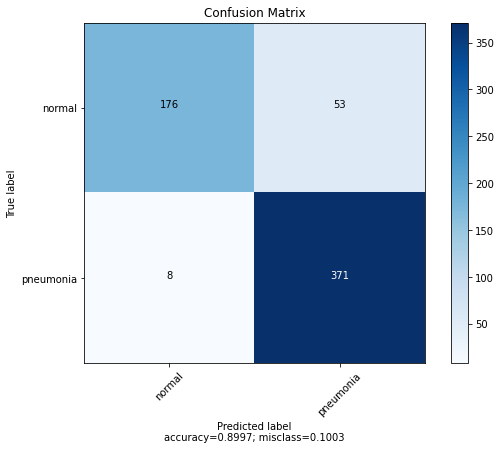

In [ ]:
preds = pf.get_predictions(model, X_val, 0.35)
pf.get_visualizations(y_val,preds)

In [ ]:
class secondary_classifier():

    def __init__(self, primary_clf_path, clf_name = 'SVM'):

        self.primary_clf_path = primary_clf_path
        self.primary_clf = load_model(self.primary_clf_path)
        self.clf_name = clf_name

    def get_classifier(self):

        try:
            if self.clf_name == 'SVM':
                from sklearn.svm import SVC
                clf = SVC(class_weight={0:1, 1:1, 2:1,3:500 }, probability = True)

                return clf
            
            if self.clf_name == 'XGBOOST':
                import xgboost as xgb
                clf = xgb.XGBClassifier(n_estimators=100, max_depth = 10, objective='multi:softprob',seed=0, silent=True, nthread=-1, learning_rate=0.1, booster='dart')
                return clf

            if self.clf_name == 'RANDOM_FOREST':
                from sklearn.ensemble import RandomForestClassifier
                clf = RandomForestClassifier(n_estimators = 100, criterion='entropy',max_depth = 10, class_weight={0:1, 1:1, 2:1, 3:500})
                return clf

        except:
            raise Exception('Invalid classifier name')


    def train(self, clf, X_train, y_train, model_save_path=0, save = False):

        primary_clf = load_model(self.primary_clf_path)
        embedding_predictor = Model(inputs = primary_clf.input, outputs = primary_clf.layers[-2].output)

        train_embeddings = embedding_predictor.predict(X_train)
        clf.fit(train_embeddings,y_train)
        print("Success")

        if save == True:
            import pickle
            pickle.dump(clf, open(model_save_path + '/sec_clf.sav','wb'))
            return clf
        return clf


    def get_visualizations(self,orig_test_labels, preds):
        def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
            import matplotlib.pyplot as plt
            import numpy as np
            import itertools
            
            
            accuracy = np.trace(cm) / float(np.sum(cm))
            misclass = 1 - accuracy
            
            if cmap is None:
                cmap = plt.get_cmap('Blues')
                
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            
            if target_names is not None:
                tick_marks = np.arange(len(target_names))
                plt.xticks(tick_marks, target_names, rotation=45)
                plt.yticks(tick_marks, target_names)
                
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                
            thresh = cm.max() / 1.5 if normalize else cm.max() / 2
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                if normalize:
                    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
                else:
                    plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
                    
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
            plt.show()
            
        import seaborn as sns
        import matplotlib.pyplot as plt
        import matplotlib.image as mimg
        from sklearn.metrics import confusion_matrix
        
        cm  = confusion_matrix(orig_test_labels, preds)
        print(cm.shape)
        plot_confusion_matrix(cm,normalize=False,target_names=['normal','bacterial','viral','covid'],title="Confusion Matrix")


    def evaluate(self, clf, X_test, y_test, visualize = True):
        primary_clf = load_model(self.primary_clf_path)
        embedding_predictor = Model(inputs = primary_clf.input, outputs = primary_clf.layers[-2].output)


        test_embeddings = embedding_predictor.predict(X_test)
        predictions = clf.predict(test_embeddings)
        acc = np.float(np.sum(predictions == y_test)) / len(y_test)
        print("Accuracy:{}".format(acc))


    def get_probabilities(self,clf, X_test, y_test, prob = True):

        primary_clf = load_model(self.primary_clf_path)
        embedding_predictor = Model(inputs = primary_clf.input, outputs = primary_clf.layers[-2].output)


        test_embeddings = embedding_predictor.predict(X_test)

        if prob == True:
          try:
              predictions = clf.predict_proba(test_embeddings)
              return predictions

          except:
              raise Exception('Classifier does not support Probabilities')
        else:
          return clf.predict(test_embeddings)


    def data_loader(self, X_train_path, y_train_path, X_test_path, y_test_path):

        X_train = np.load(X_train_path)
        y_train = np.load(y_train_path)

        X_test = np.load(X_test_path)
        y_test = np.load(y_test_path)

        for i in range(X_train.shape[0]):
            X_train[i] = np.array(X_train[i]).astype('float32') / 255.

        for i in range(X_test.shape[0]):
            X_test[i] = np.array(X_test[i]).astype('float32') / 255.

        return (X_train,y_train, X_test, y_test)


In [ ]:
model_path = '/content/drive/My Drive/pneumonia_detection/densenet/weights_v5_final_2cls.13.hdf5'

In [ ]:
sc = secondary_classifier(model_path)

In [ ]:
X_train_path = '/content/drive/My Drive/pneumonia_detection/Numpy Files/train_images.npy'
y_train_path = '/content/drive/My Drive/pneumonia_detection/Numpy Files/train_labels.npy'
X_test_path = '/content/drive/My Drive/pneumonia_detection/Numpy Files/test_images.npy'
y_test_path = '/content/drive/My Drive/pneumonia_detection/Numpy Files/test_labels.npy'

In [ ]:
X_train, y_train, X_test, y_test = sc.data_loader(X_train_path,y_train_path,X_test_path,y_test_path)

In [ ]:
sclf = sc.get_classifier()

In [ ]:
sclf = sc.train(sclf,X_train, y_train)

Success


In [ ]:
sc.evaluate(sclf, X_test,y_test)

Accuracy:0.809076682316119


In [ ]:
pred = sc.get_probabilities(sclf, X_test, y_test, prob = False)

(4, 4)


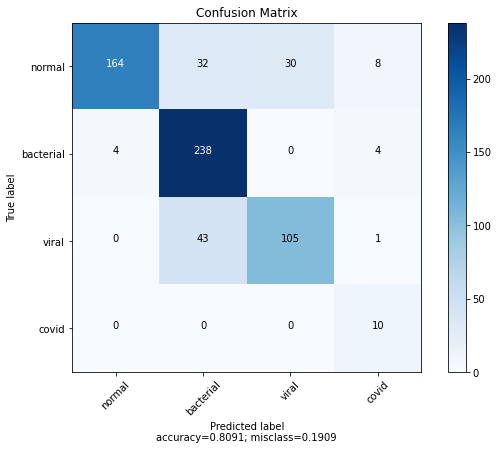

In [ ]:
sc.get_visualizations(y_test, pred)

In [ ]:
import sklearn

In [ ]:
sklearn.__version__

'0.22.2.post1'